In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
from tqdm import tqdm
import sys
sys.path.append('/fs/cbsuvlaminck2/workdir/bmg224/hiprfish/image_analysis_code')
import image_functions as imfn
# from segmentation import Segmentation


In [6]:
# from image import Image

In [7]:
cluster_path = '/fs/cbsuvlaminck2/'
data_dir = cluster_path + '/workdir/bmg224/data/2021/brc_fileshare_new/2021_06_02_plasmidairyscan/processed'
sample_names = imfn.get_sample_names(data_dir=data_dir)
refl = ['gfp', 'cy5']
factors = ['exp','method', 'plasmid','fov']
flat_field_filename = ''
print(len(sample_names))
print(sample_names[0])

47
2021_06_02_plasmidairyscan_exp_080220_method_c.1_plasmid_neg_fov_tile2_Airyscan_Processing_Stitch


In [8]:
keys =[imfn.get_filename_keys(sn, factors) for sn in sample_names]
len(keys)

47

In [1]:
# for sn, k in zip(sample_names, keys):
#     if k[1] == 'b':
#         print(sn[27:-27], k)

In [13]:
out_dir = '../image_processing'
import numpy as np
import os

In [14]:
# Get segs and raws
spot_segs, spot_raws, cell_segs, cell_raws = [],[],[],[]
for sn in tqdm(sample_names):
    ss, sr, cs, cr = [],[],[],[]
    spot_split_folder = out_dir + '/' + sn + '_spot_seg_split'
    cell_split_folder = out_dir + '/' + sn + '_cell_seg_split'
    spot_split_fns = imfn.get_sample_names(data_dir=spot_split_folder, sample_glob='*col_[012]', ext='.npy')
    cell_split_fns = imfn.get_sample_names(data_dir=cell_split_folder, sample_glob='*col_[012]', ext='.npy')
    spot_split_fns = [spot_split_folder + '/' + i for i in spot_split_fns]
    cell_split_fns = [cell_split_folder + '/' + i for i in cell_split_fns]
    # for each split file
    for sfn, cfn in zip(spot_split_fns, cell_split_fns):
        ss_fn = sfn + '_seg.npy'
        sr_fn = sfn + '.npy'
        cs_fn = cfn + '_seg.npy'
        cr_fn = cfn + '.npy'
        # Load cell and spot numpy segs and raw
        ss.append(np.load(ss_fn))
        cs.append(np.load(cs_fn))
        sr.append(np.load(sr_fn))
        cr.append(np.load(cr_fn))
    spot_segs.append(ss)
    spot_raws.append(sr)
    cell_segs.append(cs)
    cell_raws.append(cr)
    

100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


In [18]:
# Get bg pixels
bg_pixels = []
for spot_raw, cell_seg in zip(spot_raws, cell_segs):
    bg = []
    for sr, cs in zip(spot_raw, cell_seg):
        a=0
#         print(cs.shape, sr.shape)
#         bg.append(sr[cs == 0])
# bg_pixels = [rc[cs[:2000,:2000] == 0] for k, rc, cs in zip(keys, raw_corrected, cell_seg)]

080220
c.1


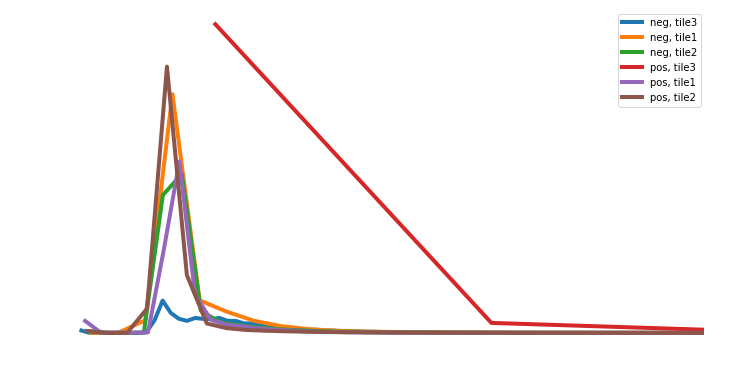

a


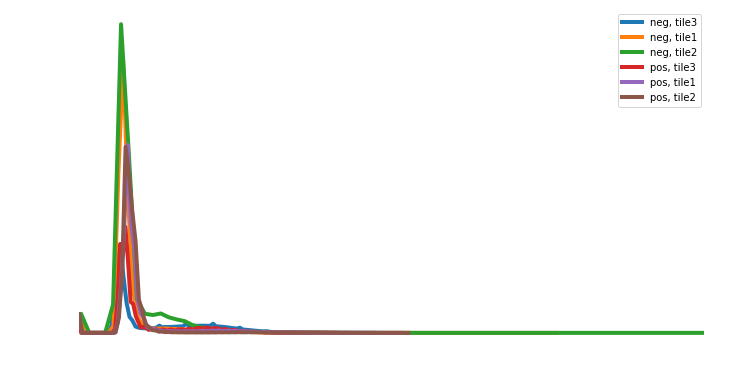

b


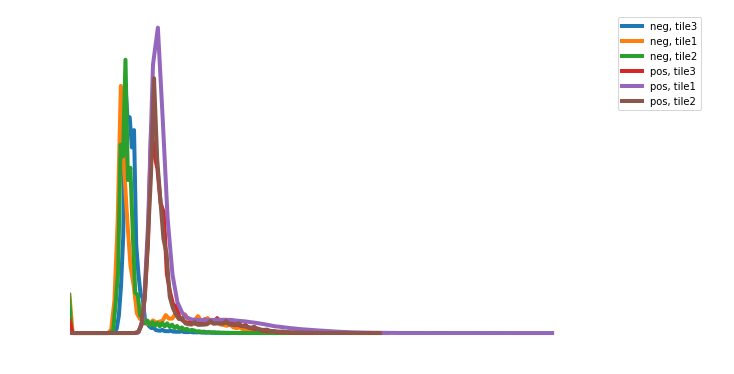

040421
c


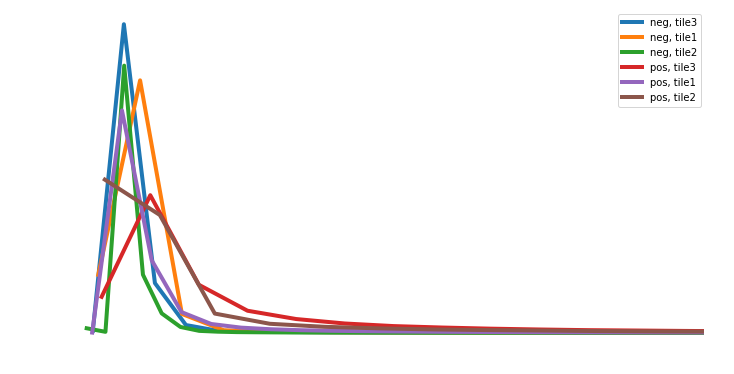

f


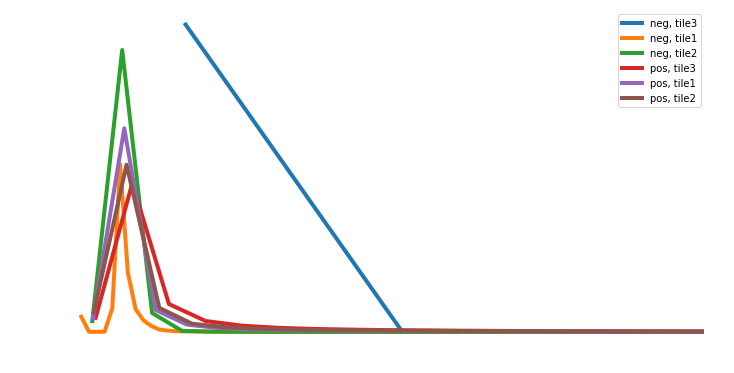

d


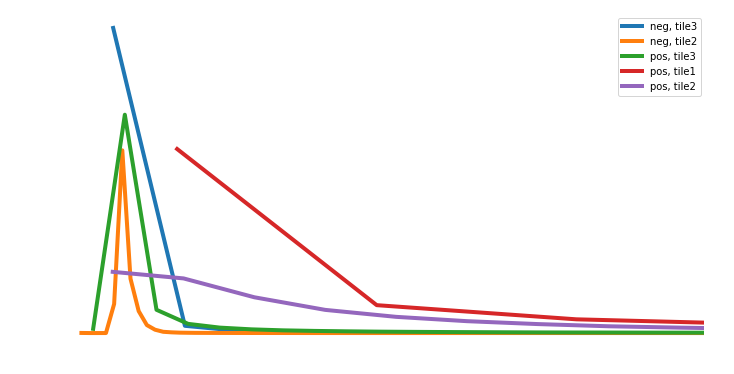

b


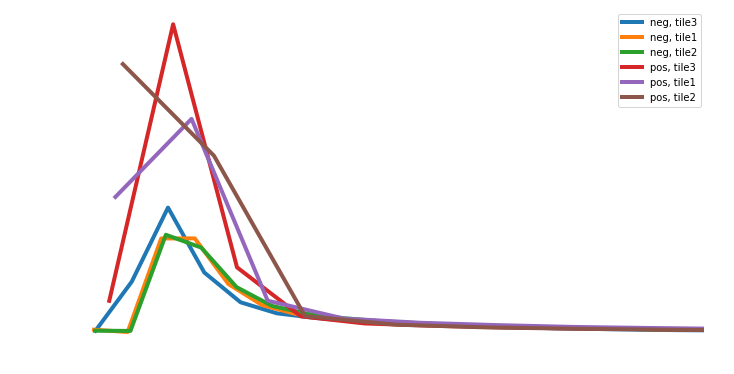

g


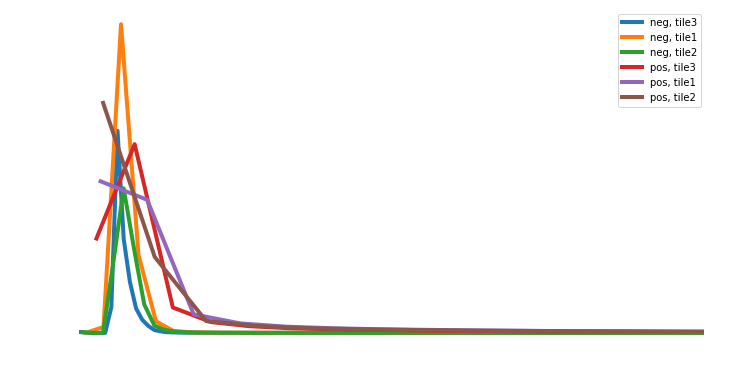

In [59]:
# Plot histogram of background pixel intensity\
import image_plots as ip
mbpi_dict = imfn.get_nested_dict(keys, bg_pixels, (0,1,2,3))
col='w'
dims=(10,5)
lw=4
ft=20
for h in mbpi_dict.keys():
    print(h)
    for i in mbpi_dict[h].keys():
        print(i)
        fig, ax = ip.general_plot(col=col, dims=dims, lw=lw,ft=ft)
        for j in mbpi_dict[h][i].keys(): 
            for k, values in mbpi_dict[h][i][j].items():
                values = values[0][1]
                y, bin_edges = np.histogram(values, bins=100)
                bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
                ax.plot(bin_centers, y, lw=lw, label=j + ', ' + k)
                
        ax.legend()
        ax.set_xlim(0,0.01)
        ip.plt.show()
        ip.plt.close
# ax.set_xlim(0.1, 0.3)


In [529]:
# Plot pixel intensity histograms

In [530]:
# Norm pixels bg pixel intensity
pixels_norm = []
mins, maxs = [],[]
for rc, mbpi in zip(raw_corrected, mbpi_new):
    pixels_norm.append(np.ravel(rc)/mbpi)
    maxs.append(np.max(pixels_norm))

In [20]:
# Load raw spot images
spot_raws_full = [np.load(out_dir + '/' + sn + '.npy')[:,:,1] for sn in sample_names]

In [59]:
# Load raw cell images
cell_raws_full = [np.load(out_dir + '/' + sn + '.npy')[:,:,0] for sn in sample_names]

In [81]:
from sklearn.cluster import MiniBatchKMeans
from scipy import ndimage as ndi
def _get_background_filter(image, n_clusters=3, top_n_clust=2, raw_2D=np.array([])):
#     raw_2D = self.raw_2D if raw_2D.shape[0] == 0 else raw_2D
#     image = self._get_2D(self.bg_filter_channel) if self.bg_filter_channel else raw_2D
#     if self.bg_log:
#         image = np.log10(image + 1e-15)
#         image = image - np.min(image)
#     if self.bg_smoothing:
    image_smooth = ndi.gaussian_filter(image, sigma=10, order=0)
#     else:
#         image_smooth = raw_2D
#     if self.bg_filter:
#     image_smooth = image
    image_bkg_filter = MiniBatchKMeans(n_clusters = n_clusters,
                                       batch_size = 100000, random_state = 42)
    shape_ = image_smooth.reshape(np.prod(image_smooth.shape), 1)
    image_bkg_filter = image_bkg_filter.fit_predict(shape_)
    image_bkg_filter = image_bkg_filter.reshape(image_smooth.shape)
    i_list = []
    for n in range(n_clusters):
        image_ = image*(image_bkg_filter == n)
        i_n = np.average(image_[image_ > 0])
        i_list.append(i_n)
    i_list = np.argsort(i_list)[::-1]
    _image_bkg_filter_mask = np.zeros(image_bkg_filter.shape, dtype=bool)
    for tn in range(top_n_clust):
        _image_bkg_filter_mask += image_bkg_filter == i_list[tn]
    return _image_bkg_filter_mask

In [86]:
cell_raws_mask = []
for cr in tqdm(cell_raws_full):
    cell_raws_mask.append(_get_background_filter(cr))

100%|██████████| 47/47 [06:02<00:00,  7.71s/it]


0it [00:00, ?it/s]

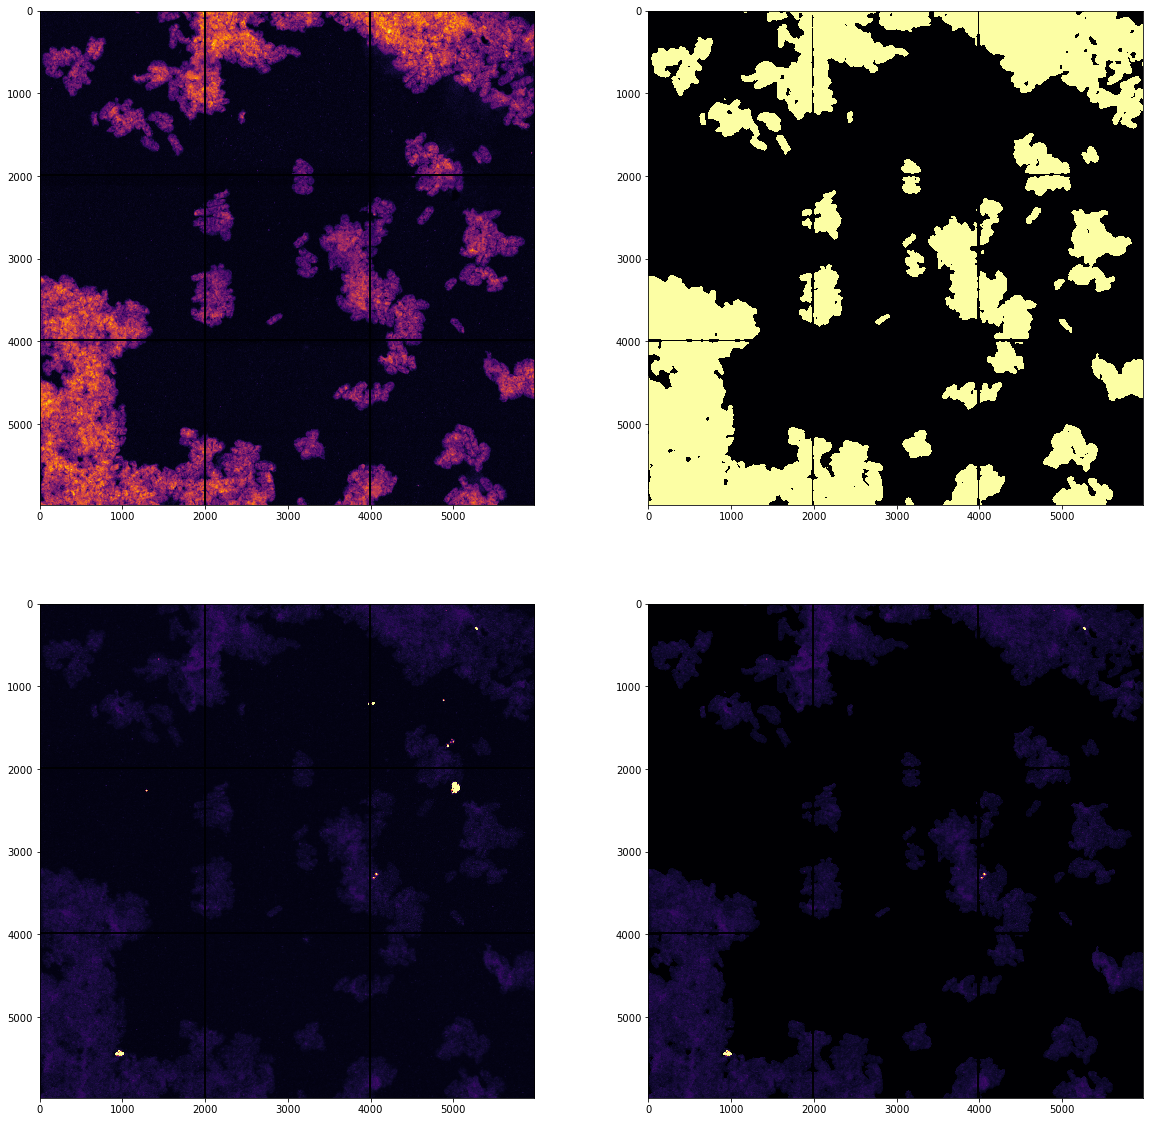

25it [00:02, 11.93it/s]

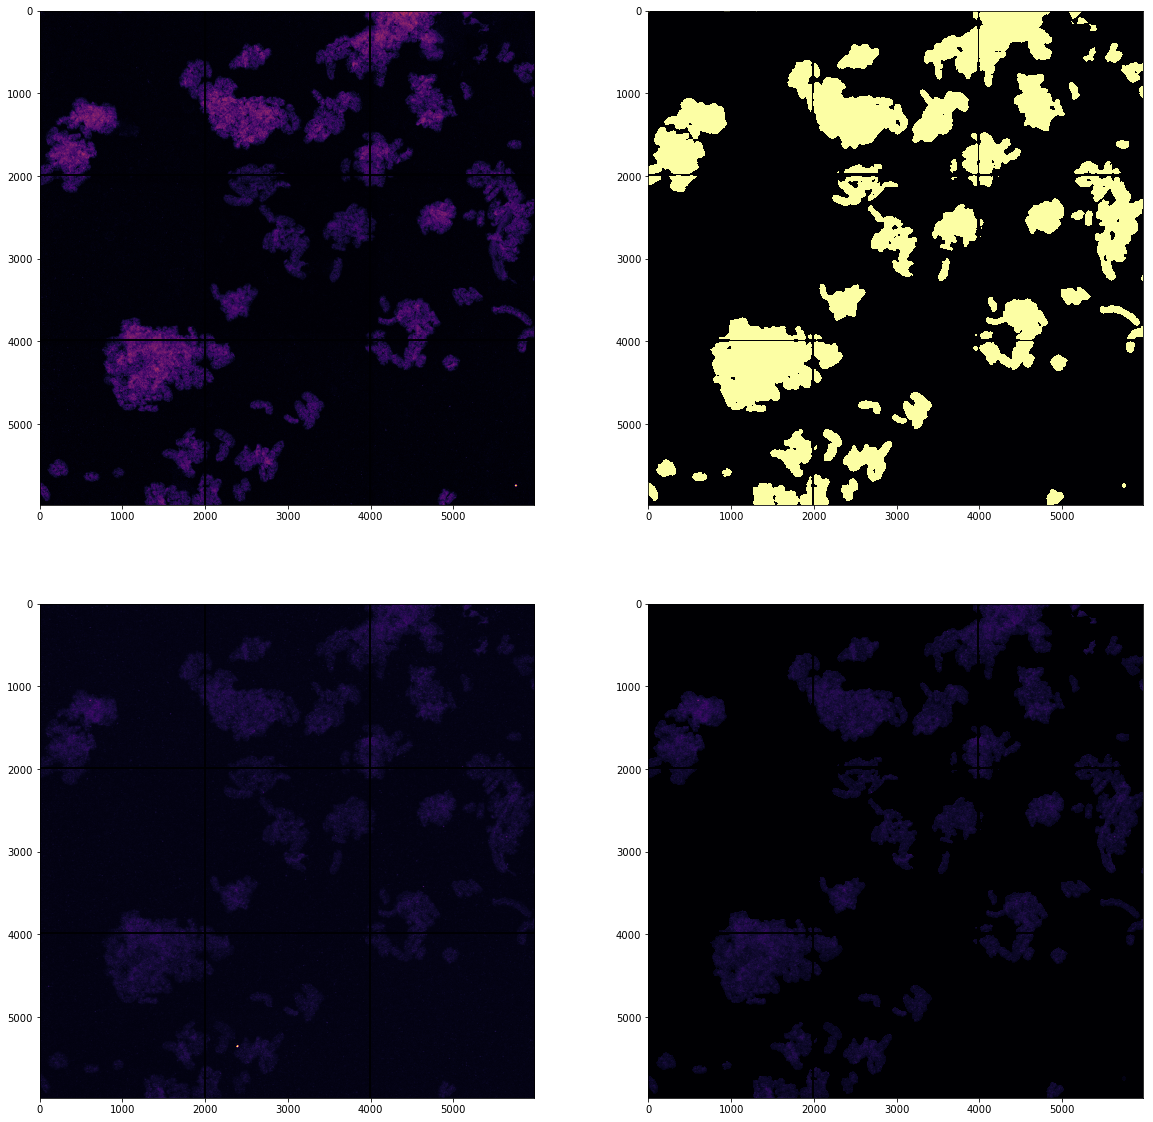

28it [00:04,  3.77it/s]

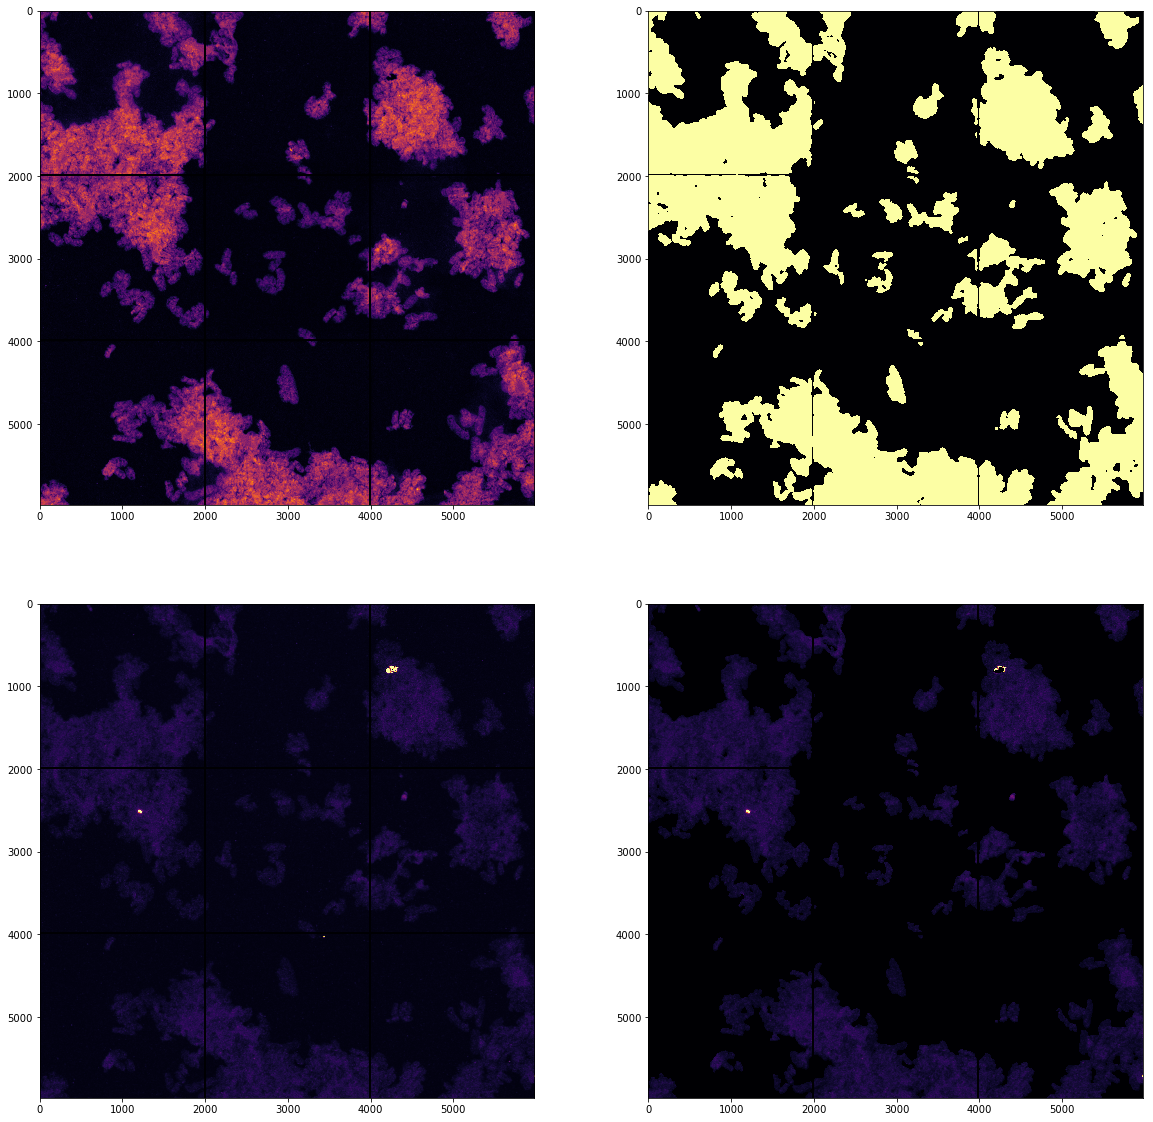

47it [00:06,  7.55it/s]


In [202]:
# show a spots...weird signal
for k, c, m, s in tqdm(zip(keys, cell_raws_full, cell_raws_mask, spot_raws_full)):
    if (k[1] == 'a') & (k[2] == 'neg'):
        fig, ((a1,a2),(a3,a4)) = plt.subplots(2,2, figsize=(20,20))
        a1.imshow(c, cmap='inferno')
        a2.imshow(m, cmap='inferno')
        a3.imshow(s, cmap='inferno',clim=(0,0.02))
        a4.imshow(s*m, cmap='inferno', clim=(0,0.02))
        plt.show()
        plt.close()


In [88]:
# Mask raw spots
pixels = []
for sr, crm in zip(spot_raws_full, cell_raws_mask):
    pixels.append(sr[crm.astype(bool)])

In [104]:
# Generate a dictionary with pixel values
pix_dict = imfn.get_nested_dict(keys, pixels, [0,1,2])

In [105]:
# Set up ordered lists of factors
H = ['080220','080220','080220','040421','040421']
I = ['a','b','c.1','b','g']
J = ['pos','neg']

In [116]:
# group pixel values and Generate histograms
rnge = (0, 0.5)
bins = 100
hist_dict = {h:{} for h in H}
for h,i in zip(H,I):
    hist_dict[h][i] = {}
    for j in J:
        pix_list = pix_dict[h][i][j]
        pix = np.array([])
        for p in pix_list:
            pix = np.concatenate([pix,p[1]])
        print(pix.shape)
        y, bin_edges = np.histogram(pix, range=rnge, bins=bins)
        hist_dict[h][i][j] = y
#         hists_pix.append(y)
        
        
# hists_pix = []
# rnge = (0, 0.5)
# for pn in pixels:
#     y, bin_edges = np.histogram(pn, range=rnge, bins=20)
#     hists_pix.append(y)

# hists = []
# rnge = (0, 1)
# for sp in spot_props_cell:
#     values = sp.Intensity.values
#     y, bin_edges = np.histogram(values, range=rnge, bins=100)
#     hists.append(y)
    
intensity_values = 0.5*(bin_edges[1:]+bin_edges[:-1])

(29542326,)
(28706221,)
(22209404,)
(25597171,)
(16779414,)
(21544135,)
(24958619,)
(47581764,)
(61054029,)
(47844250,)


In [97]:
# Generate dictionary of histograms
# hist_pix_dict = imfn.get_nested_dict(keys, hists_pix, [0,1,2])

In [117]:
len(hist_dict['080220']['a']['pos'])

100

In [115]:
# # Calculate the mean and stdev between fields of view for each set of factors
# # Generate a dictionary of mean and stdev values
# plot_dict = {h:{} for h in H}
# for h,i in zip(H,I):
#     plot_dict[h][i] = {}
#     for j in J:
#         hists = hist_pix_dict[h][i][j]
#         hist_list = [h[1] for h in hists]
#         hist_stack = np.vstack(hist_list)
#         print(hist_stack)
#         means = np.mean(hist_stack, axis=0)
#         stdevs = np.std(hist_stack, axis=0)
#         plot_dict[h][i][j] = (means, stdevs)
#         print(h,i,j)

In [122]:
# plot parameters
import image_plots as ip
import numpy as np
import matplotlib.pyplot as plt

fig_dir = '../figures'

# col = 'w'
# dims = (10,5)
# lw = 4
# ft = 20

col = 'k'
lw = 1
ft = 5
dims = (0.9843 ,0.5906)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [126]:
# Generate PLots
for h,i in zip(H,I):
    print('method: ', i,h)
    fig, ax = ip.general_plot(col=col, dims=dims, lw=lw)
    # Plot one line for each control
    line_styles = ['-',':']
    legend_labels = ['Postitive','Negative']
    line_colors = [colors[1],colors[0]]
    for j, ls, ll, lc in zip(J, line_styles, legend_labels, line_colors):
#         for k in K:
#             means = hist_dict[i][j][k][0][1]
        means = hist_dict[h][i][j]
#         means, stdevs = plot_dict[h][i][j]
#         ax.plot(intensity_values, means, linestyle=ls, lw=lw*0.75, label=ll, c=lc)
#         ax.fill_between(intensity_values, means-stdevs, means + stdevs, color=lc, alpha=0.5)
#         ax.plot(intensity_values, np.log10(means + 1), linestyle=ls, lw=lw*0.75, label=ll, c=lc)
#         ax.fill_between(intensity_values, np.log10(means-stdevs+1), np.log10(means + stdevs+1), color=lc, alpha=0.5)
        ax.plot(intensity_values, np.log10(means + 1), linestyle=ls, lw=lw*0.75, label=ll, c=lc)

    if i == 'a':
        ax.legend(fontsize=ft)
             
#     ax.set_xlim((0.5,3))
#     ax.set_ylim(-0.5, 7)
    ax.set_yticks([2,4,6])
#     ax.tick_params(labelbottom=True, bottom=True, direction='in', labelsize=ft, color=col, labelcolor=col, length=lw*2)
    ax.tick_params(labelbottom=False, bottom=True, direction='in', labelsize=ft, color=col, labelcolor=col, length=lw*2)
#     if i == 'g':
#         ax.tick_params(labelbottom=True, bottom=True, direction='in', labelsize=ft, color=col, labelcolor=col, length=lw*2)
    filename = fig_dir + '/pixel_int_histogram_method_' + h + '_' + i + '.pdf'
#     ip.plt.show()
    ip.plt.savefig(filename, transparent=True)
    ip.plt.close()


method:  a 080220
method:  b 080220
method:  c.1 080220
method:  b 040421
method:  g 040421


In [509]:
# Plot spot histograms

(2005, 2005)
(2005, 2005)
(2005, 2005)
(2005, 2005)


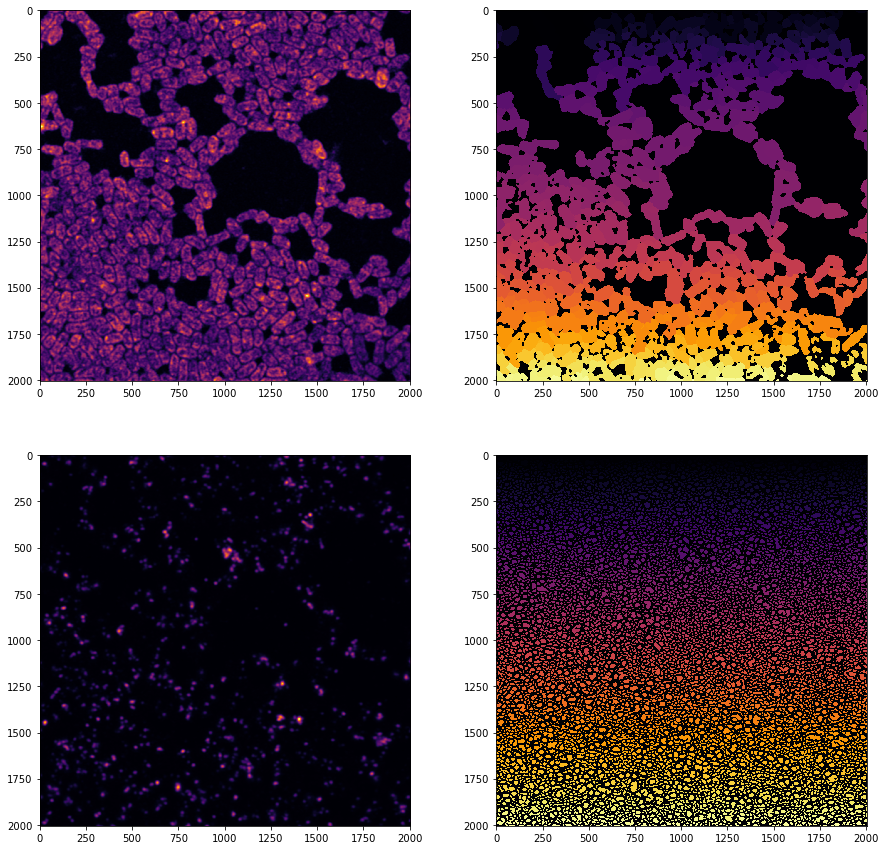

In [141]:
# Check split files
# Pick filename
cell_basename = out_dir + '/2021_06_02_plasmidairyscan_exp_040421_method_g_plasmid_pos_fov_tile3_Airyscan_Processing_Stitch_cell_seg_split/row_0_col_0' 
spot_basename = out_dir + '/2021_06_02_plasmidairyscan_exp_040421_method_g_plasmid_pos_fov_tile3_Airyscan_Processing_Stitch_spot_seg_split/row_0_col_0' 
# Load raw, spot, cell segs
fig, ((a1,a2),(a3,a4)) = plt.subplots(2,2,figsize=(15,15))
im = np.load(cell_basename+'.npy')
print(im.shape)
a1.imshow(im, cmap='inferno')
im = np.load(cell_basename+'_seg.npy')
print(im.shape)
a2.imshow(im, cmap='inferno')
im = np.load(spot_basename+'.npy')
print(im.shape)
a3.imshow(im, cmap='inferno') 
im = np.load(spot_basename+'_seg.npy')
print(im.shape)
a4.imshow(im, cmap='inferno')       
# show images

In [144]:
# Load split dirs
spot_split_dirs = [out_dir + '/' + sn + '_spot_seg_split' for sn in sample_names]
cell_split_dirs = [out_dir + '/' + sn + '_cell_seg_split' for sn in sample_names]

In [159]:
# Get split names in specific order
import glob
import re
spot_segs_split = [glob.glob(spd + '/*seg.npy') for spd in spot_split_dirs]
split_names = [[re.sub('_seg.npy','',os.path.split(n)[1]) for n in names] for names in spot_segs_split]


True

In [161]:
# load raws and segs
spot_raws_split = [[np.load(dirs + '/' +  n + '.npy') for n in names] for dirs, names in zip(spot_split_dirs, split_names)]
spot_segs_split = [[np.load(dirs + '/' +  n + '_seg.npy') for n in names] for dirs, names in zip(spot_split_dirs, split_names)]
cell_raws_split = [[np.load(dirs + '/' +  n + '.npy') for n in names] for dirs, names in zip(cell_split_dirs, split_names)]
cell_segs_split = [[np.load(dirs + '/' +  n + '_seg.npy') for n in names] for dirs, names in zip(cell_split_dirs, split_names)]


In [164]:
# Filter spot_seg by cell_seg
spot_segs_split_filt = [[s * (c > 0) for s, c in zip(sss, css)] for sss, css in zip(spot_segs_split, cell_segs_split)]

In [167]:
# Get spot properties, 
spot_props_split_fns = []
for sss, srs, sn in tqdm(zip(spot_segs_split_filt, spot_raws_split, split_names)):
    sps = []
    for s,r, n in zip(sss, srs, sn):
        out_filename = n + '_props.csv'
        props = imfn.measure_regionprops(s, r)
        props.to_csv(out_filename)
        sps.append(out_filename)
    spot_props_split_fns.append(sps)

8it [10:36, 79.61s/it]


ValueError: math domain error

In [171]:
import pandas as pd
spot_props_split = [[pd.read_csv(dirs + '/' +  n + '_props.csv') for n in names] for dirs, names in zip(spot_split_dirs, split_names)]

In [221]:
# get max intenties
max_intensities_split = [[p[p.Area < 1000].MaxIntensity.values for p in props] for props in spot_props_split]

In [222]:
# Combine sample name intensities
max_intensities = [np.concatenate(m) for m in max_intensities_split]

In [223]:
# make plot dictionary 
int_dict = imfn.get_nested_dict(keys, max_intensities, (0,1,2))

In [224]:
# Set up ordered lists of factors
H = ['080220','080220','080220','040421','040421']
I = ['a','b','c.1','b','g']
J = ['pos','neg']

In [228]:
# group pixel values and Generate histograms
rnge = (0, 0.5)
bins = 100
hist_dict = {h:{} for h in H}
for h,i in zip(H,I):
    hist_dict[h][i] = {}
    for j in J:
        pix_list = int_dict[h][i][j]
        pix = np.array([])
        for p in pix_list:
            pix = np.concatenate([pix,p[1]])
        y, bin_edges = np.histogram(pix, range=rnge, bins=bins)
        hist_dict[h][i][j] = y
#         hists_pix.append(y)
        
        
# hists_pix = []
# rnge = (0, 0.5)
# for pn in pixels:
#     y, bin_edges = np.histogram(pn, range=rnge, bins=20)
#     hists_pix.append(y)

# hists = []
# rnge = (0, 1)
# for sp in spot_props_cell:
#     values = sp.Intensity.values
#     y, bin_edges = np.histogram(values, range=rnge, bins=100)
#     hists.append(y)
    
intensity_values = 0.5*(bin_edges[1:]+bin_edges[:-1])

In [244]:
# plot parameters
import image_plots as ip
import numpy as np
import matplotlib.pyplot as plt

fig_dir = '../figures'

# col = 'w'
# dims = (10,5)
# lw = 4
# ft = 20

col = 'k'
lw = 1
ft = 5
dims = (0.9843 ,0.5906)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


method:  a 080220


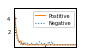

method:  b 080220


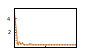

method:  c.1 080220


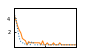

method:  b 040421


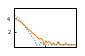

method:  g 040421


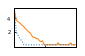

In [245]:
# Generate PLots
for h,i in zip(H,I):
    print('method: ', i,h)
    fig, ax = ip.general_plot(col=col, dims=dims, lw=lw, ft=ft)
    # Plot one line for each control
    line_styles = ['-',':']
    legend_labels = ['Postitive','Negative']
    line_colors = [colors[1],colors[0]]
    for j, ls, ll, lc in zip(J, line_styles, legend_labels, line_colors):
#         for k in K:
#             means = hist_dict[i][j][k][0][1]
        means = hist_dict[h][i][j]
#         means, stdevs = plot_dict[h][i][j]
#         ax.plot(intensity_values, means, linestyle=ls, lw=lw*0.75, label=ll, c=lc)
#         ax.fill_between(intensity_values, means-stdevs, means + stdevs, color=lc, alpha=0.5)
#         ax.plot(intensity_values, np.log10(means + 1), linestyle=ls, lw=lw*0.75, label=ll, c=lc)
#         ax.fill_between(intensity_values, np.log10(means-stdevs+1), np.log10(means + stdevs+1), color=lc, alpha=0.5)
        ax.plot(intensity_values, np.log10(means + 1), linestyle=ls, lw=lw, label=ll, c=lc)

    if i == 'a':
        ax.legend(fontsize=ft)
             
    ax.set_xlim((0 ,0.2))
    ax.set_xticks([0,0.1,0.2])
    ax.set_ylim(-0.3, 5.5)
    ax.set_yticks([2,4])
#     ax.tick_params(labelbottom=True, bottom=True, direction='in', labelsize=ft, color=col, labelcolor=col, length=lw*2)
    ax.tick_params(labelbottom=False, bottom=True, direction='in', labelsize=ft, color=col, labelcolor=col, length=lw*2)
#     if i == 'g':
#         ax.tick_params(labelbottom=True, bottom=True, direction='in', labelsize=ft, color=col, labelcolor=col, length=lw*2)
    filename = fig_dir + '/spot_int_histogram_method_' + h + '_' + i + '.pdf'
#     ip.plt.show()
    ip.plt.savefig(filename, transparent=True)
    ip.plt.close()


In [ ]:
# Plot params

In [ ]:
# Plot 

In [14]:
# load csvs
import pandas as pd
output_dir = '../image_processing'
spot_props_filenames = [output_dir + '/' + sn + '_spot_seg_props_filtered.csv' for sn in sample_names]
spot_props = [pd.read_csv(spf) for spf in spot_props_filenames]
print(len(spot_props))

47


In [15]:
# Filter by cell id
spot_props_cell = [sp[sp.dist <= 10] for sp in spot_props]

In [512]:
# Get mean background pixel intensity

In [513]:
# test sample name
sn = '2021_04_05_dnafishmethodchar_method_h_plasmid_pos_fov_1'

In [17]:
import numpy as np
# Get cell segmentation
cell_seg_filename = [output_dir + '/' + sn + '_cell_seg.npy' for sn in sample_names]
cell_seg = [np.load(csf) for csf in cell_seg_filename]

In [19]:
# Get Raw spot images (flat field corrected)
from image import Image
raw_corrected = []
for sn in sample_names:
    im = Image(sample_name=sn, illumination_names=refl, data_dir=data_dir, 
               flat_field_filename=flat_field_filename)
    im.pick_channel('cy5')
#     im.flat_field_correction()
    raw_corrected.append(im.raw_2D[:2000,:2000])

In [54]:
for i, k in enumerate(keys): 
    if k[1] == 'g': print(i, k)

5 ['040421', 'g', 'neg', 'tile3']
9 ['040421', 'g', 'neg', 'tile1']
11 ['040421', 'g', 'pos', 'tile2']
15 ['040421', 'g', 'pos', 'tile1']
16 ['040421', 'g', 'pos', 'tile3']
19 ['040421', 'g', 'neg', 'tile2']


['040421', 'g', 'neg', 'tile1']


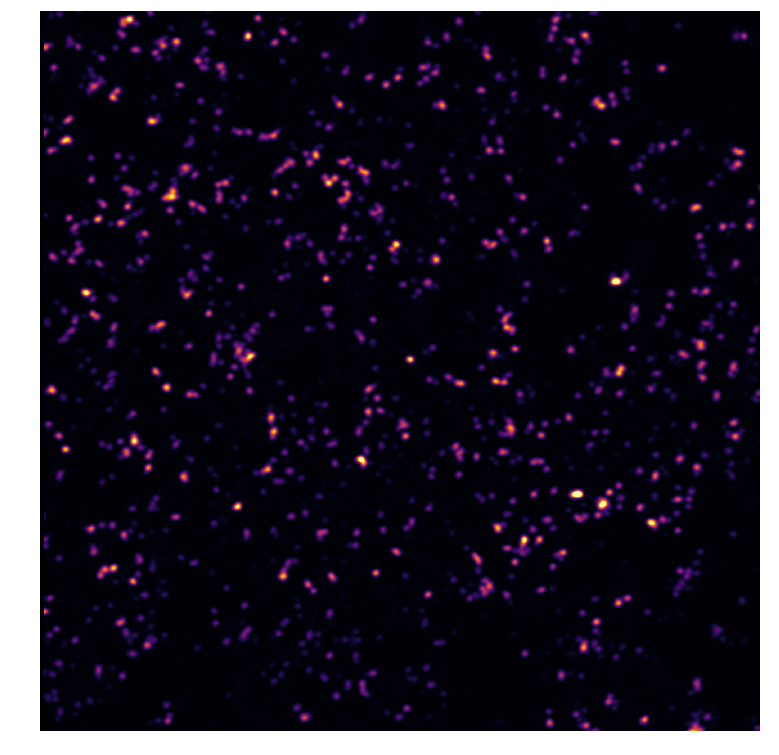

0.0 0.05


In [57]:
import matplotlib.pyplot as plt
print(keys[9])
rc = raw_corrected[11]
clims = ('min',0.05)
dims = (10,10)


fig = plt.figure(figsize=(dims[0], dims[1]))
ax = plt.Axes(fig, [0., 0., 1., 1.], )
ax.set_axis_off()
fig.add_axes(ax)
extent = 0, rc.shape[1], rc.shape[0], 0
ulim = np.max(rc) if clims[1] == 'max' else clims[1]
llim = np.min(rc) if clims[0] == 'min' else clims[0]
ax.imshow(rc, cmap='inferno', clim=(llim, ulim), extent=extent)           
plt.show()
plt.close()
print(llim, ulim)



In [558]:
# Calculate median background pixel intensity
mean_bg_pix_int = [np.median(bp) for bp in bg_pixels]
print(mean_bg_pix_int[0])

0.13898534


In [559]:
# Reset b pixel intensities as their negative controls
sample_neg_bool = [1 if ('method_b_' in sn) and ('plasmid_neg_' in sn) else 0 for sn in sample_names]
sample_pos_bool = [1 if ('method_b_' in sn) and ('plasmid_pos_' in sn) else 0 for sn in sample_names]
mbpi_neg = np.array(mean_bg_pix_int)[np.where(sample_neg_bool)]
mbpi_neg_mean = np.mean(mbpi_neg)
mbpi_new = np.where(sample_pos_bool, mbpi_neg_mean, mean_bg_pix_int)

print(np.array(mean_bg_pix_int)[np.where(sample_pos_bool)])
print(mbpi_new[np.where(sample_pos_bool)])

[0.19269446 0.18701862 0.19675678]
[0.1502299 0.1502299 0.1502299]


In [520]:
# Normalize spots

In [579]:
# Norm by bg pixel intensity
spot_props_cell_norm = []
mins, maxs = [],[]
for sc, mbpi in zip(spot_props, mbpi_new):
    scc = sc.copy()
    scc['int_norm'] = scc['Intensity']/mbpi
    maxs.append(scc.int_norm.max())
    mins.append(scc.int_norm.min())
    spot_props_cell_norm.append(scc)

In [589]:
print(spot_props_cell_norm[0].int_norm[:10])

0    1.349582
1    1.451721
2    1.369191
3    1.711089
4    1.429955
5    2.162771
6    1.474855
7    1.832192
8    1.531010
9    1.692087
Name: int_norm, dtype: float64


In [590]:
# Generate histograms

hists = []
rnge = (0, np.max(maxs))
for sp in spot_props_cell_norm:
    values = sp.int_norm.values
    y, bin_edges = np.histogram(values, range=rnge, bins=100)
    hists.append(y)

# hists = []
# rnge = (0, 1)
# for sp in spot_props_cell:
#     values = sp.Intensity.values
#     y, bin_edges = np.histogram(values, range=rnge, bins=100)
#     hists.append(y)
    
intensity_values = 0.5*(bin_edges[1:]+bin_edges[:-1])

In [591]:
# Get cell props
cell_props_filename = [output_dir + '/' + sn + '_cell_seg_props.csv' for sn in sample_names]
cell_props = [pd.read_csv(cpf) for cpf in cell_props_filename]

In [592]:
# Normalize histograms by cell count
hists_norm = []
for h, cp in zip(hists, cell_props):
    cell_count = cp.shape[0]
    hists_norm.append(h/cell_count)

# hists_norm = hists

In [593]:
# Plot normalized histograms

In [594]:
# Generate dictionary of histograms
hist_dict = imfn.get_nested_dict(keys, hists_norm, [0,1,2])

In [595]:
# Set up ordered lists of factors
I = ['a','b','c','d','e','f','g','h']
J = ['pos','neg']
K = ['1','2','3']

In [596]:
# Calculate the mean and stdev between fields of view for each set of factors
# Generate a dictionary of mean and stdev values
plot_dict = {}
for i in I:
    plot_dict[i] = {}
    for j in J:
        for k in K:
            hist_list = [hist_dict[i][j][k][0][1] for k in K]
        hist_stack = np.vstack(hist_list)
        means = np.mean(hist_stack, axis=0)
        stdevs = np.std(hist_stack, axis=0)
        plot_dict[i][j] = (means, stdevs)

In [623]:
# plot parameters
import image_plots as ip
import numpy as np
import matplotlib.pyplot as plt

fig_dir = '../figures'

col = 'w'
dims = (10,5)
lw = 4
ft = 20

# col = 'k'
# lw = 1
# ft = 5
# dims = (0.9843 ,0.5906)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


method:  a


ValueError: x and y must have same first dimension, but have shapes (250,) and (100,)

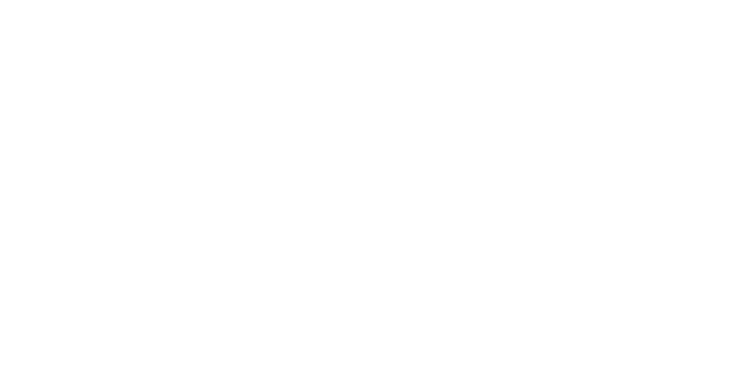

In [624]:
# Generate PLots
for i in I:
    print('method: ', i)
    fig, ax = ip.general_plot(col=col, dims=dims, lw=lw)
    # Plot one line for each control
    line_styles = ['-',':']
    legend_labels = ['Postitive','Negative']
    line_colors = [colors[1],colors[0]]
    for j, ls, ll, lc in zip(J, line_styles, legend_labels, line_colors):
#         for k in K:
#             means = hist_dict[i][j][k][0][1]
        means, stdevs = plot_dict[i][j]
#         ax.plot(intensity_values, np.log10(means+1), linestyle=ls, lw=lw*0.5, label=ll, c=lc)
#         ax.fill_between(intensity_values, np.log10(means-stdevs+1),np.log10(means + stdevs+1), color=lc, alpha=0.5)
        ax.plot(intensity_values, means, linestyle=ls, lw=lw*0.5, label=ll, c=lc)
        ax.fill_between(intensity_values, means-stdevs, means + stdevs, color=lc, alpha=0.5)

    if i == 'a':
        ax.legend(fontsize=ft)
             
#     ax.set_xlim((0.5,3))
#     ax.set_ylim(-0.1, 2.5)
    ax.tick_params(labelbottom=True, bottom=True, direction='in', labelsize=ft, color=col, labelcolor=col, length=lw*2)
#     if i == 'g':
#         ax.tick_params(labelbottom=True, bottom=True, direction='in', labelsize=ft, color=col, labelcolor=col, length=lw*2)
    filename = fig_dir + '/spot_int_histogram_method_' + i + '.pdf'
    ip.plt.show()
#     ip.plt.savefig(filename, transparent=True)
    ip.plt.close()


In [ ]:
pix_dict = imfn.get_nested_dict(keys, pixels_norm, (0,1,2))


In [ ]:
# Add plots from another folder

In [610]:
data_dir = '/fs/cbsuvlaminck2/workdir/bmg224/hiprfish/mobile_elements/experiments/2020_11_13_fullcharold/data/images'
sample_names = imfn.get_sample_names(data_dir=data_dir)
refl = ['gfp', 'cy5']
factors = ['method', 'plasmid','fov']
flat_field_filename = '/fs/cbsuvlaminck2/workdir/bmg224/data/2021/devlaminck_widefield/2021_04_12_flat_field_correction_lens_100x_refl_cy5.czi'
print(len(sample_names))
print(sample_names[0])

62
2020_11_13_fullcharold_method_b_plasmid_h_fov_2


In [611]:
keys =[imfn.get_filename_keys(sn, factors) for sn in sample_names]
len(keys)

62

In [612]:
# Get cell segmentation
cell_seg_filename = [data_dir + '/' + sn + '_cell_seg.npy' for sn in sample_names]
cell_seg = [np.load(csf) for csf in cell_seg_filename]

In [613]:
# Get Raw spot images (flat field corrected)
from image import Image
raw_corrected = []
for sn in sample_names:
    im = Image(sample_name=sn, illumination_names=refl, data_dir=data_dir, 
               flat_field_filename=flat_field_filename)
    im.pick_channel('cy5')
    im.flat_field_correction()
    raw_corrected.append(im.raw_2D)

In [614]:
len(raw_corrected)

62

In [615]:
# Get bg pixels
bg_pixels = [rc[cs == 0] for rc, cs in zip(raw_corrected, cell_seg)]

In [616]:
len(bg_pixels)

62

In [617]:
# Calculate median background pixel intensity
mean_bg_pix_int = [np.median(bp) for bp in bg_pixels]
print(mean_bg_pix_int[0])

0.02199048


In [618]:
len(mean_bg_pix_int)

62

In [619]:
# Norm pixels bg pixel intensity
pixels_norm = []
mins, maxs = [],[]
for rc, mbpi in zip(raw_corrected, mean_bg_pix_int):
    pixels_norm.append(np.ravel(rc)/mbpi)
    maxs.append(np.max(pixels_norm))

In [620]:
# Generate histograms

hists_pix = []
rnge = (0, np.max(maxs))
for pn in pixels_norm:
    y, bin_edges = np.histogram(pn, range=rnge, bins=250)
    hists_pix.append(y)

# hists = []
# rnge = (0, 1)
# for sp in spot_props_cell:
#     values = sp.Intensity.values
#     y, bin_edges = np.histogram(values, range=rnge, bins=100)
#     hists.append(y)
    
intensity_values = 0.5*(bin_edges[1:]+bin_edges[:-1])

In [621]:
# Generate dictionary of histograms
hist_pix_dict = imfn.get_nested_dict(keys, hists_pix, [0,1,2])

In [622]:
print(np.max(maxs))

62.93145


In [ ]:
# Set up ordered lists of factors
I = ['a','b','c.1']
J = ['h','c']
K = ['1','2','3']

In [ ]:
# Calculate the mean and stdev between fields of view for each set of factors
# Generate a dictionary of mean and stdev values
plot_dict = {}
for i in I:
    plot_dict[i] = {}
    for j in J:
        for k in K:
            hist_list = [hist_pix_dict[i][j][k][0][1] for k in K]
        hist_stack = np.vstack(hist_list)
        means = np.mean(hist_stack, axis=0)
        stdevs = np.std(hist_stack, axis=0)
        plot_dict[i][j] = (means, stdevs)

In [ ]:
# plot parameters
import image_plots as ip
import numpy as np
import matplotlib.pyplot as plt

fig_dir = '../figures'

# col = 'w'
# dims = (10,5)
# lw = 4
# ft = 20

col = 'k'
lw = 1
ft = 5
dims = (0.9843 ,0.5906)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [ ]:
# Generate PLots
for i in I:
    print('method: ', i)
    fig, ax = ip.general_plot(col=col, dims=dims, lw=lw)
    # Plot one line for each control
    line_styles = ['-',':']
    legend_labels = ['Postitive','Negative']
    line_colors = [colors[1],colors[0]]
    for j, ls, ll, lc in zip(J, line_styles, legend_labels, line_colors):
#         for k in K:
#             means = hist_dict[i][j][k][0][1]
        means, stdevs = plot_dict[i][j]
#         ax.plot(intensity_values, means, linestyle=ls, lw=lw*0.75, label=ll, c=lc)
#         ax.fill_between(intensity_values, means-stdevs+1, means + stdevs, color=lc, alpha=0.5)
        ax.plot(intensity_values, np.log10(means + 1), linestyle=ls, lw=lw*0.75, label=ll, c=lc)
        ax.fill_between(intensity_values, np.log10(means-stdevs+1), np.log10(means + stdevs+1), color=lc, alpha=0.5)

    if i == 'a':
        ax.legend(fontsize=ft)
             
#     ax.set_xlim((0.5,10))
    ax.set_ylim(-0.5, 7)
    ax.set_yticks([2,4,6])
    ax.tick_params(labelbottom=True, bottom=True, direction='in', labelsize=ft, color=col, labelcolor=col, length=lw*2)
#     if i == 'g':
#         ax.tick_params(labelbottom=True, bottom=True, direction='in', labelsize=ft, color=col, labelcolor=col, length=lw*2)
    filename = fig_dir + '/pixel_int_histogram_fullcharold_method_' + i + '.pdf'
    ip.plt.show()
#     ip.plt.savefig(filename, transparent=True)
    ip.plt.close()
